In [1]:
from kubernetes import client, config
from matplotlib import pyplot as plt
from __future__ import print_function
from pprint import pprint
from PIL import Image
from dateutil.tz import tzlocal
import datetime
import time
import yaml
import urllib3
import urllib2

# Disable ssl warning
urllib3.disable_warnings()

# Configs can be set in Configuration class directly or using helper
# utility. If no argument provided, the config will be loaded from
# default location.
config.load_kube_config(config_file='config.yml')

# APIs
core = client.CoreV1Api()
batch = client.BatchV1Api()
logs = client.LogsApi()

# Default namespace
namespace = 'default'

# Helper functions

In [22]:
def get_client_job_template():
    """ Get client job template.
    """
    try:
        with open("inception-client-job.yml", 'r') as stream:    
            body = yaml.load(stream)
    except yaml.YAMLError as e:
        print(e)
    return body
    
def delete_job(job_name):
    """ Delate a named job.
    """
    try:
        print("Deleting", job_name)
        batch.delete_namespaced_job(name=job_name,namespace=namespace,body={})
        # Wait until deletion is complete
        while get_job_timestamps_by_job_name(job_name) != (None, None):
            pass
    except Exception as e:
        print(e)

def create_job(job_name, body):
    """ Create a new job.
    """
    try:
        print("Creating", job_name)
        batch.create_namespaced_job(namespace=namespace,body=body)
        # Wait until creation is complete
        while get_job_timestamps_by_job_name(job_name) == (None, None):
            pass        
    except client.rest.ApiException as e:
        print (e)        
        
def get_all_active_jobs():
    """ Get a list of all active jobs.
    """
    jobs = dict()
    raw = dict()
    for job in batch.list_job_for_all_namespaces().items:
        jobs[job.metadata.name] = dict(started_at=job.status.start_time, finished_at=job.status.completion_time)
        raw[job.metadata.name] = job
    return jobs, raw

def get_job_timestamps_by_job_name(job_name):
    """ Get job status by job name.
    """
    jobs, raw = get_all_active_jobs()
    if jobs.has_key(job_name):
        return jobs[job_name], raw[job_name]
    else:
        return None, None

def get_pods_by_job_name(job_name):
    """ Get list of pods.
    """
    pods = dict()
    raw = dict()
    for pod in core.list_pod_for_all_namespaces(watch=False).items:
        if pod.metadata.labels.has_key('job-name') and pod.metadata.namespace == namespace:
            if job_name in pod.metadata.labels['job-name']:
                pods[pod.metadata.name] = dict(
                    node=pod.spec.node_name,
                    phase=pod.status.phase
                )
                raw[pod.metadata.name] = pod
    return pods, raw

def parse_result_log_by_pod_name(pod_name):
    """ Parse a pod log.
    """
    log = core.read_namespaced_pod_log(pod_name, namespace=namespace).split('\n')
    result = dict(
        confidence=list(),
        category=list()
    )
    for line in log:
        search = 'Location: '
        if search in line:
            result['url'] = line.split(search)[1].strip('\r')
        search = 'float_val: '
        if search in line:
            result['confidence'].append(float(line.split(search)[1]))
        search = 'string_val: '
        if search in line:
            result['category'].append(line.split(search)[1].strip('"'))
    return result, log

def get_results_and_logs(pods, raw_pods):
    """ Get pod logs and return parsed results.
    """
    results = dict()
    logs = dict()
    for pod_name, val in pods.items():
        if val['phase'] == 'Succeeded':
            result, log = parse_result_log_by_pod_name(pod_name)
            result['started_at'] = raw_pods[pod_name].status.container_statuses[0].state.terminated.started_at
            result['finished_at'] = raw_pods[pod_name].status.container_statuses[0].state.terminated.finished_at            
            result['t_delta'] = result['finished_at'] - result['started_at']
            results[pod_name] = result
            logs[pod_name] = log
    return results, logs

def get_pod_name_sorted_by_finished_at(results):
    """ Get list of pods sorted by finished_at timestamp.
    """
    return list(reversed(sorted(results, key=lambda k: results[k]['finished_at'])))

def plot_results(results,pods,to_plot=8):
    """ Visualise results.
    """
    sorted_keys = get_pod_name_sorted_by_finished_at(results)
    to_plot = min(to_plot, len(sorted_keys))
    plt.figure(figsize=(10,to_plot*4))
    for i,key in enumerate(sorted_keys[:to_plot]):
        result = results[key]
        y = list(reversed(result['confidence']))
        x_label = list(reversed(result['category']))
        x = range(len(x_label))    
        
        # plot confidence chart
        plt.subplot(to_plot, 2, i*2+1)
        plt.barh(x,y)
        plt.yticks(x, x_label)

        # display image
        plt.subplot(to_plot, 2, i*2+2)
        f = urllib2.urlopen(result['url'])
        a = Image.open(f)
        plt.imshow(plt.np.array(a), cmap='Greys_r')
        plt.title((pods[key]['node'], str(results[key]['t_delta'])))

# Run everything

__NOTE__: It may take longer than usual for the job to run for the first time because kubernetes will need to download the images required to provision the pods.

Creating inception-client
A job has been running for: 0:00:22.698348

Deleting inception-client


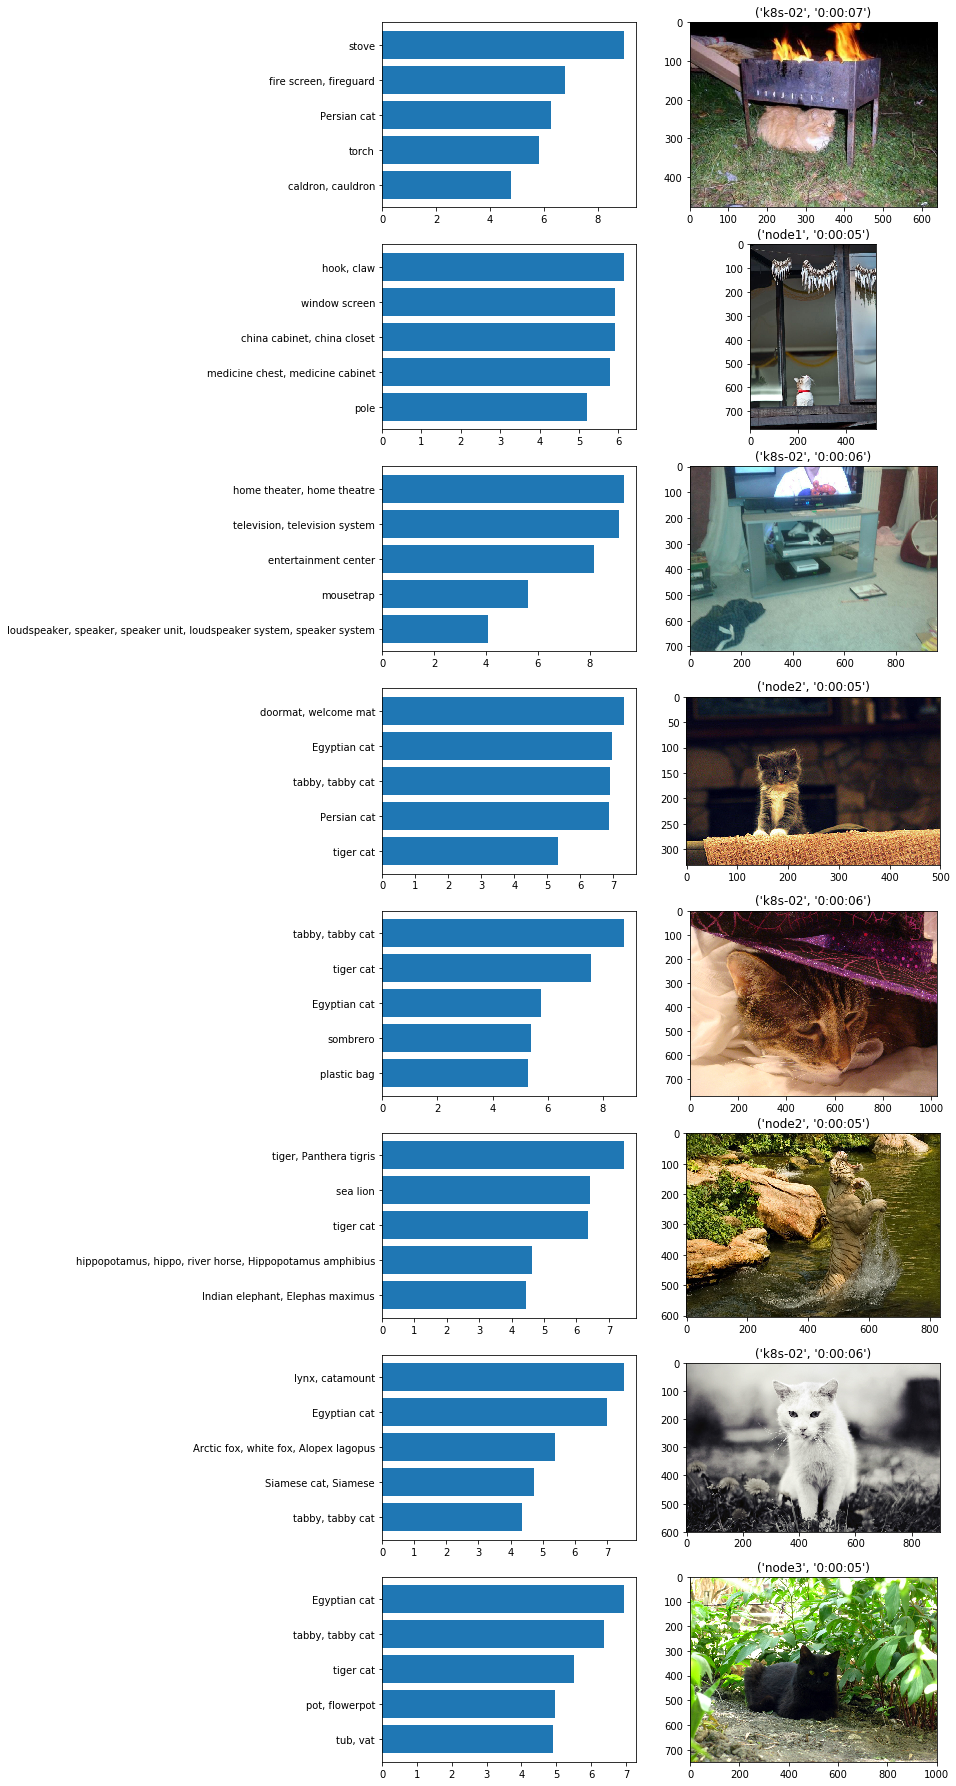

In [29]:
# get job template
body = get_client_job_template()

# get job name
job_name = body['metadata']['name']

# create a new job
create_job(job_name, body)

# check if a job is in progress
job_in_progress = True

while job_in_progress:

    # Get job status
    job, raw_job = get_job_timestamps_by_job_name(job_name)
        
    # if there is no completed timestamp, flag job as incomplete
    job_in_progress = job['finished_at'] == None

    if job_in_progress:
        if job['started_at'] != None:
            print("A job has been running for:", datetime.datetime.now(tz=tzlocal()) - job['started_at'], end='\r')
        time.sleep(1)
    else:
        # Start a new line
        print('\n')
        
        # Get pods
        pods, raw_pods = get_pods_by_job_name(job_name)

        # Get latest results
        results, logs = get_results_and_logs(pods, raw_pods)

        # Plot when finished
        plot_results(results, pods)

        # Deleting complete job
        delete_job(job_name)